In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from scipy import signal

from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_image(image):
    fig, ax = plt.subplots()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    ax1 = ax.imshow(image) 
    fig.colorbar(ax1, cax=cax, orientation='vertical')
    plt.show()


## creation de l'image d'entrée

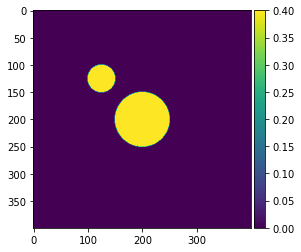

In [315]:
sizex=400 # admettons que 100=>1km
sizey=400
centerx=int(sizex/2)
centery=int(sizey/2)
im = Image.new('F', [sizey,sizex])
draw = ImageDraw.Draw(im)
draw.ellipse((centery-50,  centerx-50,centery+50,centery+50), fill=(0.4))

draw.ellipse((centery-100,  centerx-100,centery-50,centery-50), fill=(0.4))

cercle=np.asarray(im)

#figure
show_image(cercle)



# creation d'un noyau de convolution gaussien 2D

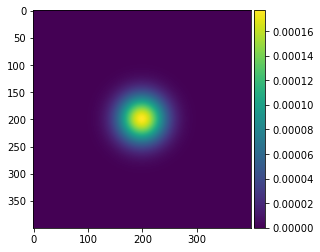

In [306]:
def gauss2D(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum() #la somme du noyau de convolution vaut 1

gauss=gauss2D(400, 30)
show_image(gauss)


# Creation de l'image d'effets d'environnement
- Pour obtenir cette image à partir de SMART-G, il faudra appliquer une formule issue de cette page :
https://labo.obs-mip.fr/multitemp/les-effets-denvironnement-comment-ca-marche/
Il faut isoler $\rho_env$
- cette modélisation est une approximation, on verra si elle n'est pas trop mauvaise. j'espère qu'elle est bonne, sinon, il va falloir réfléchir.
- Pour calculer les transmissions, les formules sont dans lib-lut.py. Elles nécessitent quelques simulations avec SMART-G pour calculer les transmissions.Je dois avoir un document qui explique le calcul, n'oubliez pas de me le demander. Il est possible que SMART-G permette directement d'accéder aux transmissions sans utiliser ces calculs.

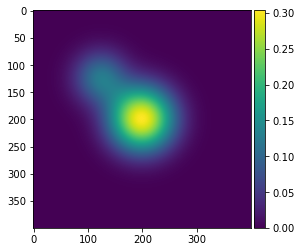

In [307]:
#rho_env=signal.convolve2d(cercle, gauss, boundary='symm', mode='same')
rho_env=signal.fftconvolve(cercle, gauss)[sizex-centerx:sizex+centerx,sizey-centery:sizey+centery]
show_image(rho_env)


# Extraction du noyau de convolution
la transformée de Fourier d'une convolution est le produit des transformées de Fourier de chacun des termes de la convolution. Il faut diviser l'image d'effet d'environnement par l'image en entrée pour obtenir la réponse impulsionnelle

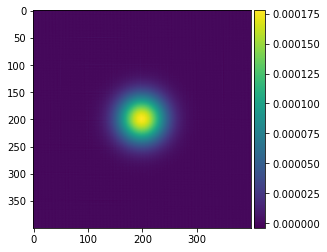

In [314]:
# calcul de la transformée de fourier 2D
## fft de l'image rho_env  
fft_env=np.fft.fft2(rho_env)

## fft de l'image \rho_surf
fft_surf=np.fft.fft2(cercle)

## Division
fft_gauss=fft_env/fft_surf

gauss2=np.fft.ifft2(fft_gauss) # une fft fournit un nombre complexe


#remise dans l'ordre (on décale le tout pour mettre le maximum au milieu)
gauss_3=np.roll(gauss2,centerx,axis=0)
gauss_final=np.roll(gauss_3,centery,axis=1)
show_image(gauss_final.real)


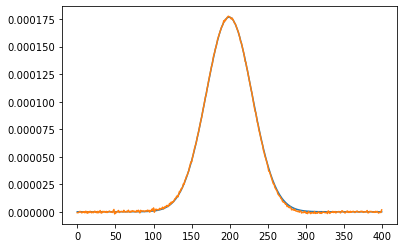

In [6]:

plt.plot(gauss[centerx,:])
plt.plot(gauss_final.real[centerx,:])


# Et voila ;)

# II. Application à une image Smartg

In [1]:
################################### Required imports ###################################
#
# Smartg
%pylab inline
# next 2 lines allow to automatically reload modules that have been changed externally
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.insert(0, os.path.dirname(os.getcwd()))
from smartg.smartg import Smartg, Sensor
from smartg.smartg import RoughSurface, LambSurface, FlatSurface, Environment, Albedo_cst
#from smartg.smartg import RTLSSurface
from smartg.atmosphere import AtmAFGL, AeroOPAC, CloudOPAC, diff1, read_phase
from smartg.water import IOP_1, IOP, IOP_profile
from smartg.reptran import REPTRAN, reduce_reptran
from smartg.tools.tools import SpherIrr, Irr, reduce_Irr
from luts.luts import LUT, MLUT, Idx, merge, read_mlut
from smartg.tools.smartg_view import compare, plot_polar, spectrum , mdesc 
from smartg.tools.smartg_view import spectrum_view,transect_view,profile_view,phase_view,smartg_view,input_view
import warnings
warnings.filterwarnings("ignore")




from scipy import signal

Populating the interactive namespace from numpy and matplotlib


## Chargement de l'image simulée par SmartG

Text(0, 0.5, 'y (km)')

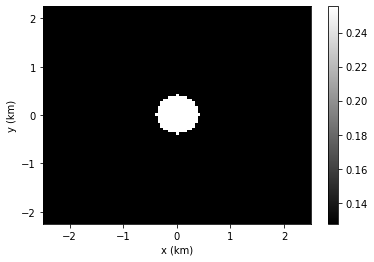

In [2]:
filename = 'VZA_0_VAA_0_SZA_0_SAA_0_tauR_0.1_aerosol_continental_average_0.4_wl_443_P_25_km2_NP_51x49_r_400m_z_700_km_NB_1.25e+10'
m = read_mlut(os.getcwd() + '/Results/aerosols_continental_average/' + filename +'.hdf')


#
Ix = m['Ix'][:]
Iy = m['Iy'][:]
NX = len(Ix)
NY = len(Iy)


# Reshape reflectance values as a matrix corresponding to the picture
rho = m['I_up (TOA)'][:, -1].reshape((NY,NX))


# Center x and y for image and plot
x_image_min = min(Ix-mean(Ix))
x_image_max = max(Ix-mean(Ix))
y_image_min = min(Iy-mean(Iy))
y_image_max = max(Iy-mean(Iy))


# Image
fix, ax = subplots()
pcolor(Ix, Iy, rho, vmin=rho.max()*0.2, vmax = rho.max()*0.4, cmap='gray')
ax.set_yticks([-2, -1, 0, 1, 2])
colorbar()
xlabel('x (km)')
ylabel('y (km)')


# other customs
#
# scale between x and y
#axis("equal")
# affichage des axes
#ax.axis('on')
#
# suppression du cadre trait par trait / pour tout supprimer d'un coup : ax.set_frame_on(False)
#x.spines['left'].set_visible(False)
#
# position de la graduation des ordonnées
#ax.yaxis.set_tick_params(pad=0)
#
# couleur des ticks
#pyplot.tick_params(axis = 'y', color='k')

# Etape préliminaire : interpolation de l'image

- initialement, l'échantillonage (x,y) est irrégulier
- l'interpolation sert à le rendre régulier
- le pas de ce nouvel échantillonnage correspond au plus petit pas utilisé pour l'échantillonage initial

In [3]:
# définition du nouvel échantillonnage (xnew, ynew)
#
pas_x = 0.050
pas_y = 0.050
#
nb_x_new = int(1+(Ix.max()-Ix.min())/pas_x)
nb_y_new = int(1+(Iy.max()-Iy.min())/pas_y)
#
xnew = linspace(Ix.min(), Ix.max(), num=nb_x_new)
ynew = linspace(Iy.min(), Iy.max(), num=nb_y_new)

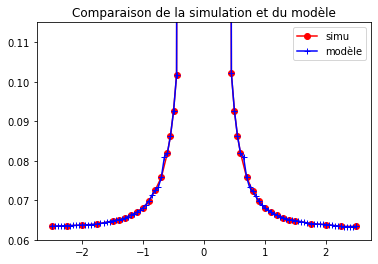

In [27]:
from scipy import interpolate

# creation de fonction à partir de la matrice et de son échantillonnage initial
# f:(x,y)-> rho
f = interpolate.interp2d(Ix, Iy, rho, kind='cubic')

# définition du nouvel échantillonnage
xnew = linspace(Ix.min(), Ix.max(), num=nb_x_new)
ynew = linspace(Iy.min(), Iy.max(), num=nb_y_new)

# création de la matrice interpolée avec le nouvel échantillonnage
rho_new = f(xnew, ynew)

# comparaison
plt.plot(Ix, rho[len(rho)//2, :], 'ro-', label = 'simu') 
plot(xnew, rho_new[len(rho_new)//2, :], 'b+-', label = 'modèle')
legend()
title('Comparaison de la simulation et du modèle')
ylim(0.06, 0.115)
#ylim(0.45, 0.52)
plt.show()


### Comparaison des 2 images (simulation et modèle)

modele_min - simu_min = 0.0
modele_max - simu_max = 1.1102230246251565e-16


Text(0.5, 0.92, 'modèle')

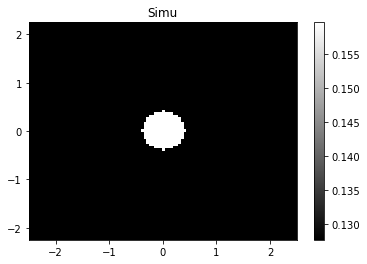

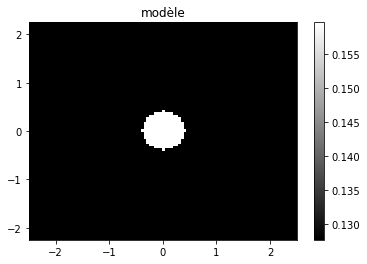

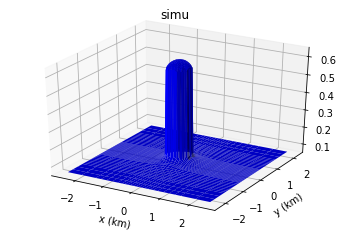

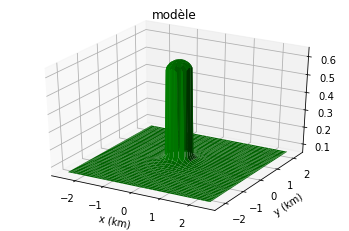

In [5]:
# comparaison des 2 images (simulation et modèle)


print('modele_min - simu_min = ' + str(rho_new.min()-rho.min()))
print('modele_max - simu_max = ' + str(rho_new.max()-rho.max()))


vmin = rho.max()*0.2
vmax = rho.max()*0.25


# Simulation
fix, ax = subplots()
pcolor(Ix, Iy, rho, vmin=vmin, vmax = vmax, cmap='gray')
ax.set_yticks([-2, -1, 0, 1, 2])
colorbar()
title('Simu')


# Modèle
fix, ax = subplots()
pcolor(xnew, ynew, rho_new, vmin=vmin, vmax = vmax, cmap='gray')
ax.set_yticks([-2, -1, 0, 1, 2])
colorbar()
title('modèle')


# simu
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_x_, _y_ = np.meshgrid(Ix, Iy)
ax.plot_surface(_x_, _y_, rho, vmax=20, color='b')
xlabel('x (km)')
ylabel('y (km)')
title('simu')


# modèle
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_x_, _y_ = np.meshgrid(xnew, ynew)
ax.plot_surface(_x_, _y_, rho_new, vmax=20, color='g')
xlabel('x (km)')
ylabel('y (km)')
title('modèle')

## Définition de la surface étudiée


remarque : le paramètre 'r' n'est pas lu automatiquement pour l'instant

Text(0.5, 1.0, 'Surface étudiée - r=400m')

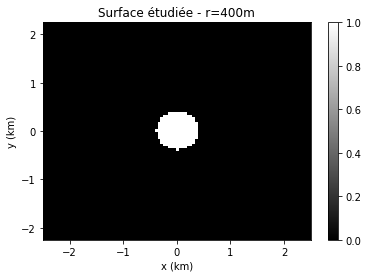

In [6]:
r = 0.4
rho_s = np.zeros((len(ynew), len(xnew)))


for j in range(0, len(rho_s)) :
    for i in range(0, len(rho_s[j])) :
        if sqrt(xnew[i]**2+ynew[j]**2) <= r :
            rho_s[j][i] = 1
        else : 
            rho_s[j][i] = 0


fix, ax = subplots()
pcolor(xnew, ynew, rho_s, cmap='gray')
ax.set_yticks([-2, -1, 0, 1, 2])
colorbar()
xlabel('x (km)')
ylabel('y (km)')  
title('Surface étudiée - r=400m')

Min = 0.0
Max = 1.0


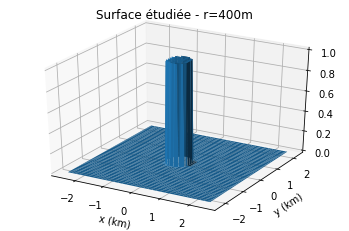

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_x_, _y_ = np.meshgrid(xnew, ynew)
ax.plot_surface(_x_, _y_, rho_s, vmax=20)
xlabel('x (km)')
ylabel('y (km)')
title('Surface étudiée - r=400m')

print('Min = ' + str(rho_s.min()))
print('Max = ' + str(rho_s.max()))

# Extraction du noyau de convolution

### 1. Correction atmosphérique de l'image dans l'hypothèse de paysage uniforme



On peut démontrer que :

$\rho_{TOA} = \rho_{atm} + $ $T^{\downarrow}T^{\uparrow}\rho_{s,unif} \over 1-\rho_{s,unif}s$


d'où :

$\rho_{s,unif} = $ $\rho_{TOA} - \rho_{atm} \over (\rho_{TOA} - \rho_{atm})*s + T^{\downarrow}T^{\uparrow}$

=> pour chaque pixel, on peut alors calculer la valeur de $\rho_{s,unif}$ associée.

=> on peut calculer la nouvelle image $\rho_{s,unif}$ 


### 2. Détermination de $\rho_{env}$


En réalité, nous savons que toutes les valeurs précédemment calculée de $\rho_s$ ne sont pas issues d'un paysage totalement uniforme. Il faut donc corriger cette réflectance en incluant les effets d'environnement.

Pour un paysage non uniforme, on peut montrer que : 

$\rho_{TOA} = \rho_{atm} + $ $T^{\downarrow} \over 1-\rho_{env}s$ $(\rho_s T^{\uparrow}_{dir} + \rho_{env} T^{\uparrow}_{dif})$
  
  
=> on peut alors isoler $\rho_{env}$ grâce à la combinaison deux précédentes formules : 

$\rho_{s} T^{\uparrow}_{dir} = \rho_{s, unif}T^{\uparrow}$  ${1-\rho_{s, unif}s } \over {1-\rho_{env}s}$ $- \rho_{env}T^{\uparrow}_{dif}$
  
=> ...

=> $T^{\uparrow}_{dif}s\rho_{env}^2 + (T^{\uparrow}_{dir}s\rho_s-T^{\uparrow}_{dif})\rho_{env} + \rho_{unif}T^{\uparrow}(1-\rho_{unif}s)-T^{\uparrow}_{dir}\rho_s = 0$

### 3. Détermination des coefficients de ces précédentes équations


1. $\rho_{atm} = \rho_{TOA}$ pour une simulation avec un pixel __noir__.



2. Pour une simulation avec un pixel __blanc__, le calcul de $\rho_{TOA}$ inclue la valeur de $\rho_{atm}$. Il faut donc la retrancher pour accéder à $T^{\uparrow}$.
    
    $T^{\uparrow} = $ $\rho_{TOA pixel blanc}-\rho_{atm} \over \rho(0^+, up)_{pixel blanc}$
    

3. $T^{\uparrow}_{dir}$ : dans SmartG, un paramètre est calculé automatiquement à chaque simulation:  _'direct transmission'_. Il vaut la même valeur quel que soit le sol (pixel blanc, pixel noir, ou simulation 'principale'). Alors, on a $T^{\downarrow}_{dir} = $ _direct transmission_. Ainsi, en réalisant une autre simulation en inversant le Soleil et le satellite, la valeur de _direct transmission_ correspondra à $T^{\uparrow}_{dir} $


4. $T^{\uparrow}_{dif} = T^{\uparrow} - T^{\uparrow}_{dir}$


5. $T^{\downarrow} $ : refaire une simulation avec un pixel __blanc__ en inversant le Soleil et le satellite. Le calcul du point 2 donnera cette fois $T^{\downarrow}$ au lieu de $T^{\uparrow}$


6. D'après le formulaire d'Olivier : 

    $s=$ $\rho_{\Delta2} / \rho_{s2} - \rho_{\Delta1} / \rho_{s1} \over \rho_{\Delta2} - \rho_{\Delta1}$ avec $\rho_{\Delta,i} = \rho_{TOA,i}-\rho_{atm}$
    
    Nécessite une simulation (en plus de celle où $\rho_{s1}=1$) : par exemple $\rho_{s2} = 0.5$ 
    
    
On a donc 5 simulations supplémentaires à faire en plus de chaque simulation "principale" : 
- $\rho_s = 0$
- $\rho_s = 0.5$
- $\rho_s = 1$
- inverser Soleil et satellite et $\rho_s = 0$
- inverser Soleil et satellite et $\rho_s = 1$

Ces simulations durent de l'ordre d'1 minute chacune pour $5.10^8$ photons (correspondant à un bruit maximal de $3.9*10^{-5}$)

In [8]:
# définition des fonctions rho_unif et rho_env


filename = 'coefficients_VZA_0_VAA_0_SZA_0_SAA_0_tauR_0.1_aerosol_continental_average_0.4_wl_443_z_700_km_NB_5.00e+08'

def solve_coefficients(filename) :
    # load 2 files
    loaded_object = read_mlut(os.getcwd() + '/Results/aerosols_continental_average/' + filename +'.hdf')
    loaded_object_reverse = read_mlut(os.getcwd() + '/Results/aerosols_continental_average/' + 'reverse_' + filename +'.hdf')
    # pixel noir
    rho_atm = float(loaded_object['I_up (TOA)'][Idx(0), :])
    # pixel blanc
    rho_TOA_pixel_blanc = float(loaded_object['I_up (TOA)'][Idx(1),:])
    rho_0_up = float(loaded_object['I_up (0+)'][Idx(1),:])
    # pixel "gris"
    rho_TOA_pixel_gris = float(loaded_object['I_up (TOA)'][Idx(0.5),:])
    # Soleil et satellite inversés
    rho_atm_reverse = float(loaded_object_reverse['I_up (TOA)'][Idx(0), :])
    rho_TOA_pixel_blanc_reverse = float(loaded_object_reverse['I_up (TOA)'][Idx(-1),:])
    rho_0_up_reverse = float(loaded_object_reverse['I_up (0+)'][Idx(-1),:])
    #    
    T_up = (rho_TOA_pixel_blanc-rho_atm)/rho_0_up
    Tdir_up = float(loaded_object['direct transmission'][Idx(0),:])
    Tdif_up = T_up - Tdir_up
    T_down = (rho_TOA_pixel_blanc_reverse-rho_atm_reverse)/rho_0_up_reverse
    s = ((rho_TOA_pixel_blanc-rho_atm)/1-(rho_TOA_pixel_gris-rho_atm)/0.5)/(rho_TOA_pixel_blanc-rho_TOA_pixel_gris)
    return rho_atm, T_up, Tdir_up, Tdif_up, T_down, s

coef = solve_coefficients(filename)
rho_atm = coef[0]
T_up = coef[1]
Tdir_up = coef[2]
Tdif_up = coef[3]
T_down = coef[4]
s = coef[5]



In [9]:
coef = solve_coefficients(filename)
print(coef)

rho_atm = coef[0]
T_up = coef[1]
Tdir_up = coef[2]
Tdif_up = coef[3]
T_down = coef[4]
s = coef[5]

(0.0628510898041449, 0.8595302507756132, 0.5351134586521391, 0.3244167921234741, 0.8595555852468884, 0.15201869920283742)


In [12]:
def solve_rho_unif(rho_atm, rho_TOA, T_up, T_down, s):
    rho_unif = np.zeros((len(rho_TOA), len(rho_TOA[0])))
    for j in range(0, len(rho_unif)) :
        for i in range(0, len(rho_unif[0])) :
            rho_unif = (rho_TOA-rho_atm)/((rho_TOA-rho_atm)*s+T_up*T_down)
    return rho_unif



In [13]:
rho_unif = solve_rho_unif(rho_atm, rho_new, T_up, T_down, s)

In [14]:
rho_unif

array([[ 3.74808257e-04,  2.90810739e-04,  2.51132541e-04, ...,
         2.20108222e-04,  3.10257880e-04,  4.50605145e-04],
       [ 3.24013865e-04,  2.82925382e-04,  2.72793540e-04, ...,
         3.40144278e-04,  3.49825080e-04,  3.56209411e-04],
       [ 3.12375821e-04,  2.93128371e-04,  2.97786623e-04, ...,
         4.25567892e-04,  3.83299321e-04,  3.04391649e-04],
       ...,
       [ 3.20680043e-04,  2.74360002e-04,  2.45574691e-04, ...,
         4.82665179e-04,  4.24974614e-04,  3.18660337e-04],
       [ 2.98748306e-04,  3.44948149e-04,  3.72763043e-04, ...,
         3.37833862e-04,  2.79944230e-04,  1.91485261e-04],
       [ 3.12998782e-04,  4.88095449e-04,  5.93600472e-04, ...,
         1.24136625e-04,  5.91257100e-05, -7.44834565e-06]])

max(rho_unif) = 0.696554264665486
min(rho_unif) = -7.448345651734583e-06


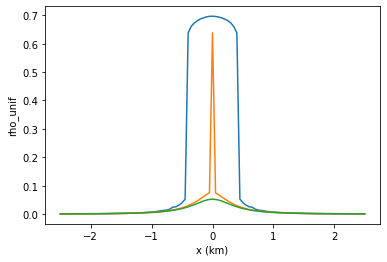

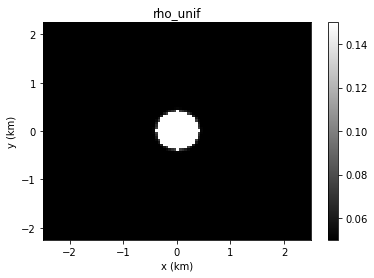

In [15]:
# Plot
plot(xnew, rho_unif[len(rho_unif)//2])
plot(xnew, rho_unif[len(rho_unif)//2+8])
plot(xnew, rho_unif[len(rho_unif)//2+9])
xlabel('x (km)')
ylabel('rho_unif')

# Image
fix, ax = subplots()
pcolor(xnew, ynew, rho_unif, vmin=0.05, vmax = 0.15, cmap='gray')
ax.set_yticks([-2, -1, 0, 1, 2])
colorbar()
title('rho_unif')
xlabel('x (km)')
ylabel('y (km)')

print('max(rho_unif) = ' + str(rho_unif.max()))
print('min(rho_unif) = ' + str(rho_unif.min()))

In [16]:
def solve_rho_env(rho_unif, rho_atm, rho_TOA, rho_s, T_up, T_down, s):    
    rho_env = np.zeros((len(rho_TOA), len(rho_TOA[0])))
    for j in range(0, len(rho_env)) :
        for i in range(0, len(rho_env[0])) :
            rho_env[j][i] = (rho_unif[j][i]*T_up-rho_s[j][i]*Tdir_up*(1-rho_unif[j][i]*s))/(rho_unif[j][i]*T_up*s+(1-rho_unif[j][i]*s)*Tdif_up)
    return rho_env

In [17]:
rho_env = solve_rho_env(rho_unif, rho_atm, rho_new, rho_s, T_up, T_down, s)

In [19]:
rho_env.max()

1.4572532951918198

In [25]:
rho_env.mean()

0.015897611166597204

max(rho_env) = 1.4572532951918198
min(rho_env) = -1.9734152233505242e-05


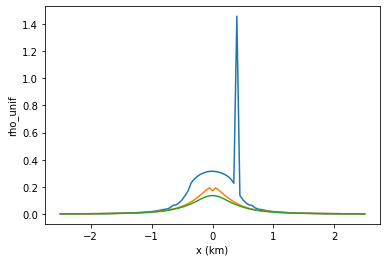

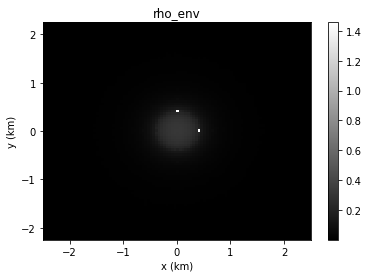

In [24]:
# Plot
plot(xnew, rho_env[len(rho_env)//2])
plot(xnew, rho_env[len(rho_env)//2-8])
plot(xnew, rho_env[len(rho_env)//2-9])
xlabel('x (km)')
ylabel('rho_unif')

# Image
fix, ax = subplots()
pcolor(xnew, ynew, rho_env, cmap='gray')
ax.set_yticks([-2, -1, 0, 1, 2])
colorbar()
title('rho_env')
xlabel('x (km)')
ylabel('y (km)')

print('max(rho_env) = ' + str(rho_env.max()))
print('min(rho_env) = ' + str(rho_env.min()))

### Vrac (inutile de regarder)

In [267]:
# test

#valeur min de rho toa = .06284558686812483
#valeur max de rho toa = 0.6384219295400936
rho_toa = 0.6384219295400936

# rho_unif
x = Symbol('x')
rho_unif = solve(rho_atm - rho_toa+T_up*T_down*x/(1-x*s),x)
rho_unif = float(str((rho_unif[0])))
print(rho_unif)

#rho_env
rho_surface = 1
solve(rho_unif*T_up*(1-rho_unif*s)/(1-x*s)-x*Tdif_up-rho_surface*Tdir_up,x)

0.644837931801294


[-2.62632128232552, 6.22266807537020]

In [137]:
float((solve(rho_atm - rho_TOA+T_up*T_down*x/(1-x*s),x)[0]))

0.6448379318012938

In [273]:
# rho env

# d'après la formule (9)
solve(0.5077408990277098*0.9264094750819103*(1-0.5077408990277098*0.10594924924355184)/(1-x*0.10594924924355184)-x*0.13539773063862226-1*0.791011744443288,x)


[-3.43141842570423, 7.02776521874892]

In [66]:
# d'après la formule (3)
solve(rho_atm+T_down*(rho_s*Tdir_up+x*Tdif_up)/(1-x*s)-rho_TOA,x)

[-0.716685875155897]

In [77]:
a=solve(1+x*x,x)

In [97]:
a = [9]

In [99]:
a[0].is_complex

AttributeError: 'int' object has no attribute 'is_complex'

### 2. Transformée de Fourier et déconvolution

Min = -0.5869172428327019
Max = 0.5227191037226786


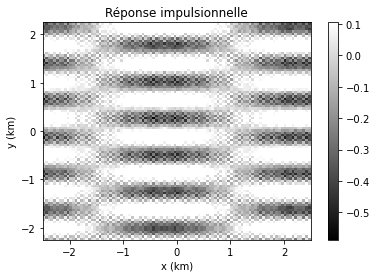

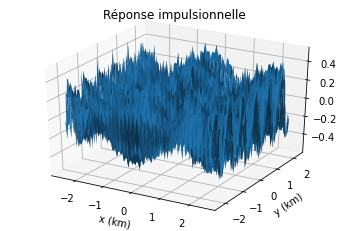

In [299]:
# calcul de la transformée de fourier 2D
## fft de l'image rho_env  
fft_env=np.fft.fft2(rho_new)

## fft de l'image \rho_surf
fft_surf=np.fft.fft2(surface_reelle)

## Division
fft_gauss=fft_env/fft_surf
# fft^-1
gauss2=np.fft.ifft2(fft_gauss) # une fft fournit un nombre complexe


#remise dans l'ordre (on décale le tout pour mettre le maximum au milieu)
gauss_3=np.roll(gauss2,len(xnew)//2,axis=0)
gauss_final=np.roll(gauss_3,len(ynew)//2,axis=1)
fix, ax = subplots()
pcolor(xnew, ynew, gauss_final.real, vmin=gauss_final.real.min(), vmax=gauss_final.real.max()/5, cmap='gray')
ax.set_yticks([-2, -1, 0, 1, 2])
colorbar()
xlabel('x (km)')
ylabel('y (km)')  
title('Réponse impulsionnelle')




fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_x_, _y_ = np.meshgrid(xnew, ynew)
ax.plot_surface(_x_, _y_, gauss_final.real)
title('Réponse impulsionnelle')
xlabel('x (km)')
ylabel('y (km)')


print('Min = ' + str(gauss_final.real.min()))
print('Max = ' + str(gauss_final.real.max()))

Text(0.5, 1.0, 'Image reconstituée')

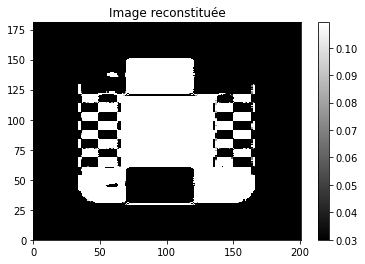

In [300]:
## Comparaison : calcul de la convolution

check=signal.fftconvolve(surface_reelle, gauss_final.real)
fix, ax = subplots()
pcolor(check, vmin=rho.min(), vmax=0.03, cmap='gray')
colorbar()
#ax.set_yticks([-2, -1, 0, 1, 2])
#xlabel('x (km)')
#ylabel('y (km)')  
title('Image reconstituée')

Text(0, 0.5, 'Reflectance')

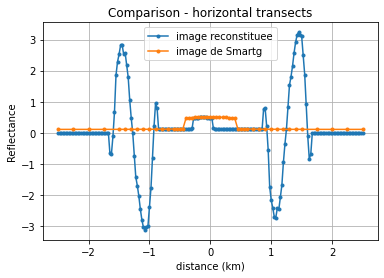

In [301]:
h_transect = check[len(check)//2, :]
v_transect = check[:, len(check[:])//2]


plot(np.linspace(-2.5, 2.5, num=len(h_transect)), h_transect, '.-', label="image reconstituee")
#plot(np.linspace(-2.25, 2.25, num=len(v_transect)), v_transect, label="vertical transect")

title("Comparison - horizontal transects")
plot(Ix-mean(Ix), rho[len(rho)//2], '.-', label="image de Smartg")
legend()
grid()
xlabel('distance (km)')
ylabel('Reflectance')

### Constat 

Les résultats ne sont pas excellents car la réponse impulsionnelle n'est pas une gaussienne parfaite. Il faut alors remplacer la réponse impulsionnelle trouvée par une gaussienne, et ensuite comparer l'image reconstituée et l'image simulée par SmartG.

In [15]:
from functools import reduce
import operator
import statistics


def gauss2D(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum() #la somme du noyau de convolution vaut 1

1.0


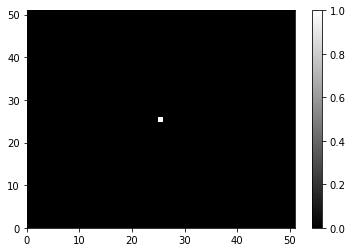

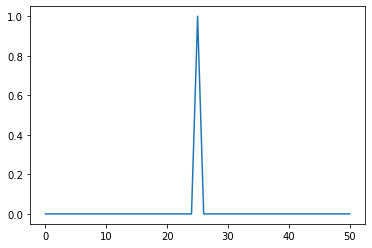

In [16]:
# calcul de l'écart-type de la réponse impulsionnelle trouvée
# Change the type
L_gauss_final = reduce(operator.concat, gauss_final.real)
Sigma = statistics.stdev(L_gauss_final)

# reconstruction d'une gaussienne
new_gauss=gauss2D(51, Sigma)
pcolor(new_gauss, cmap='gray', vmax=1)
colorbar()


figure()
#plot(gauss_final.real[len(gauss_final.real)//2])
plot(new_gauss[len(new_gauss)//2])
#ylim(-0.005, 0.1)

print(new_gauss.max())

Text(0.5, 1.0, 'Image reconstituée')

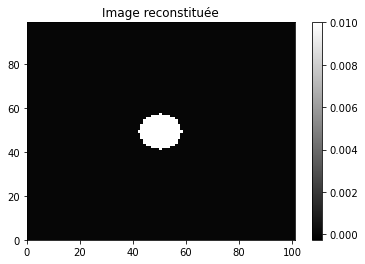

In [17]:
new_check=signal.fftconvolve(surface_reelle, new_gauss)
fix, ax = subplots()
pcolor(new_check, vmin=rho.min(), vmax=.01, cmap='gray')
colorbar()
#ax.set_yticks([-2, -1, 0, 1, 2])
#xlabel('x (km)')
#ylabel('y (km)')  
title('Image reconstituée')

Text(0, 0.5, 'Reflectance')

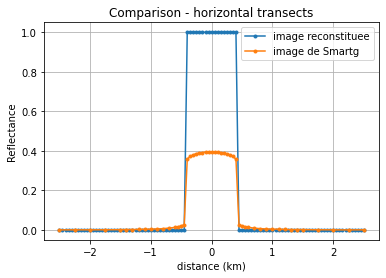

In [18]:
# check 

h_transect = new_check[len(new_check)//2, :]
v_transect = new_check[:, len(new_check[:])//2]


plot(np.linspace(-2.5, 2.5, num=len(h_transect)), h_transect, '.-', label="image reconstituee")
#plot(np.linspace(-2.25, 2.25, num=len(v_transect)), v_transect, label="vertical transect")

title("Comparison - horizontal transects")
plot(Ix-mean(Ix), rho[len(rho)//2], '.-', label="image de Smartg")
legend()
grid()
xlabel('distance (km)')
ylabel('Reflectance')
#ylim(0, 0.01)